Network Traffic Anomaly Detection System
Using Isolation Forest, DBSCAN, and Statistical Methods

Dataset: NSL-KDD Network Intrusion Detection Dataset
Download from: https://www.kaggle.com/datasets/hassan06/nslkdd
File to use: KDDTrain+.txt and KDDTest+.txt

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Network Traffic Anomaly Detection System

Please ensure you have downloaded the NSL-KDD dataset from:
https://www.kaggle.com/datasets/hassan06/nslkdd

Uploading files using Google Colab...


Saving KDDTest+.txt to KDDTest+.txt
Saving KDDTrain+.txt to KDDTrain+.txt
Loading NSL-KDD training data...
Loading NSL-KDD test data...
Preprocessing data...
Preprocessing data...
Training dataset shape: (125973, 41)
Test dataset shape: (22544, 41)
Training anomaly ratio: 0.4654
Calculating statistical thresholds...

Training models and detecting anomalies...
Training Isolation Forest...
Training DBSCAN...
Detecting statistical anomalies...

MODEL EVALUATION RESULTS

ISOLATION FOREST RESULTS:
------------------------------
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      9711
           1       0.82      0.81      0.81     12833

    accuracy                           0.79     22544
   macro avg       0.78      0.79      0.79     22544
weighted avg       0.79      0.79      0.79     22544

Confusion Matrix:
[[ 7420  2291]
 [ 2469 10364]]
Precision: 0.8190
Recall: 0.8076
F1-Score: 0.8132
Accuracy: 0.7889

DBSCAN RESULTS:
-----------

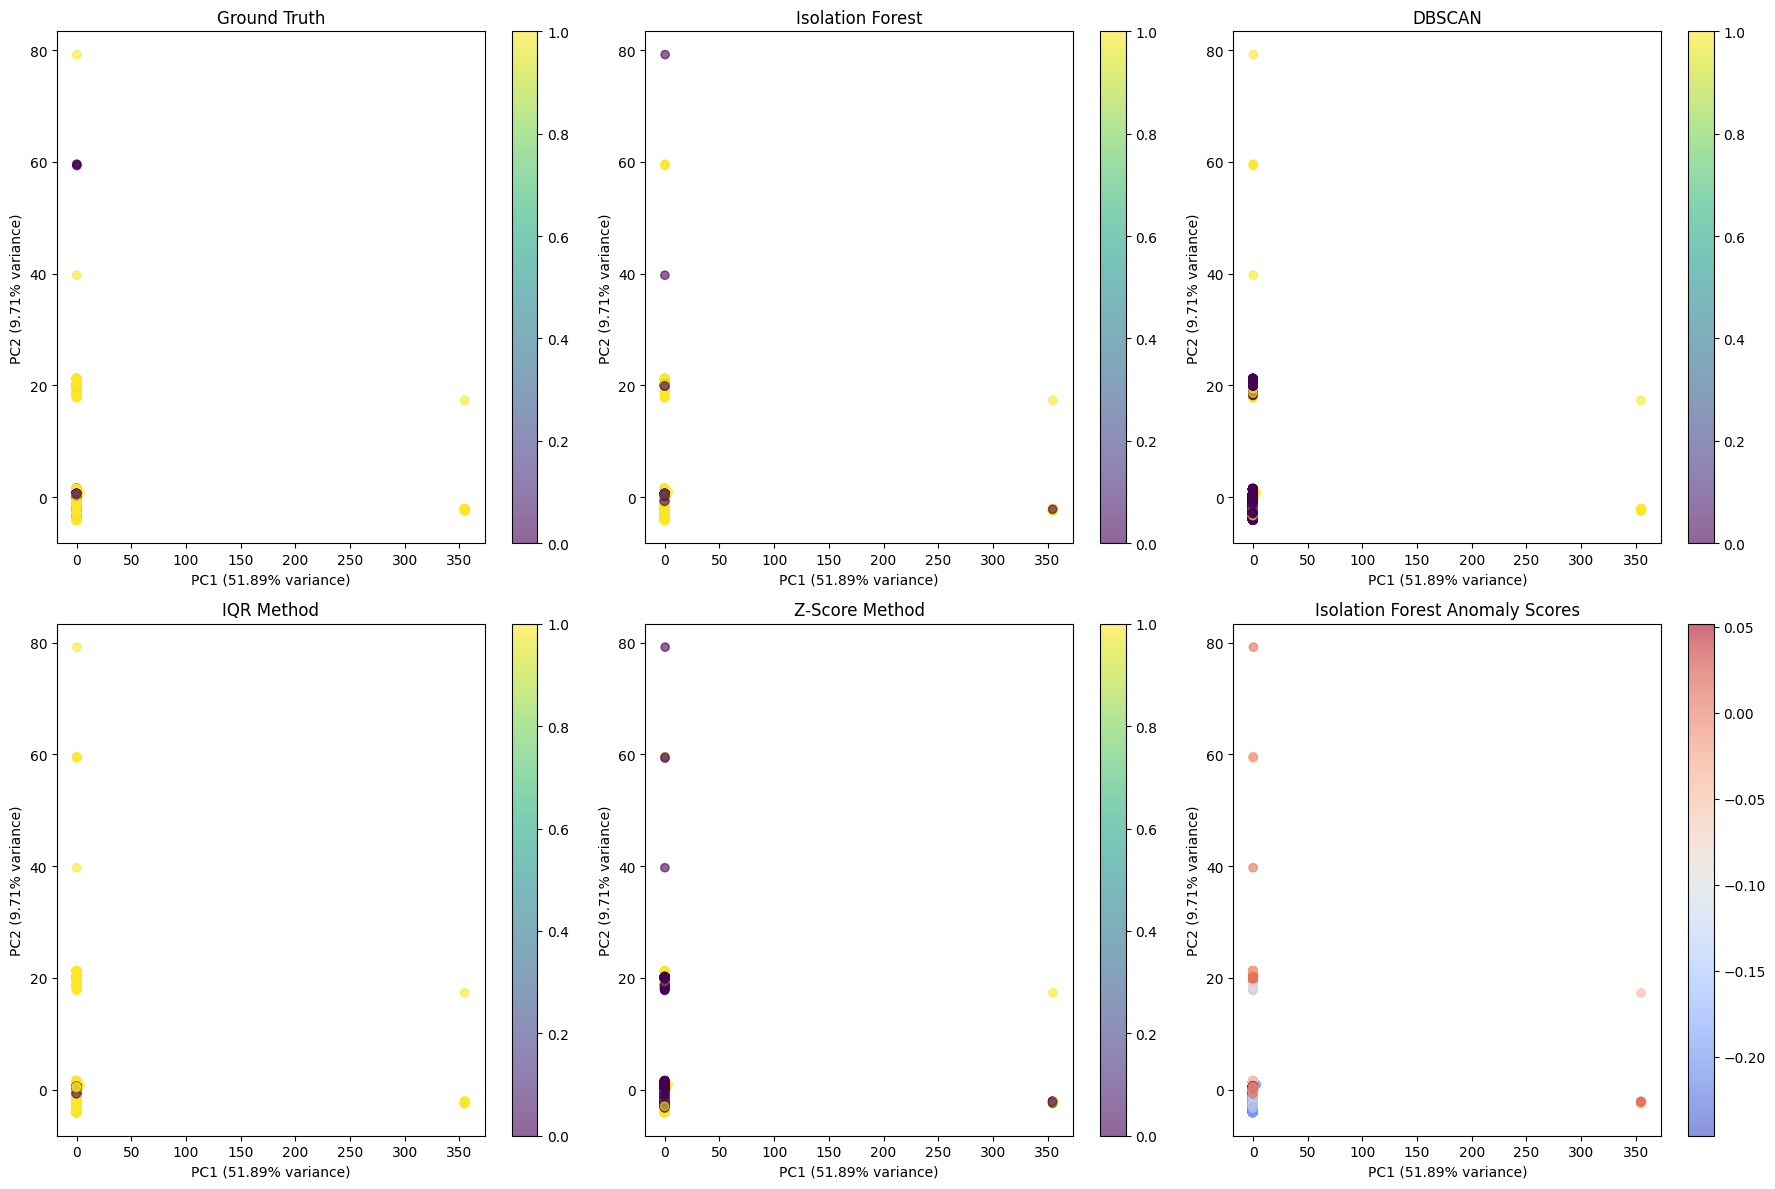

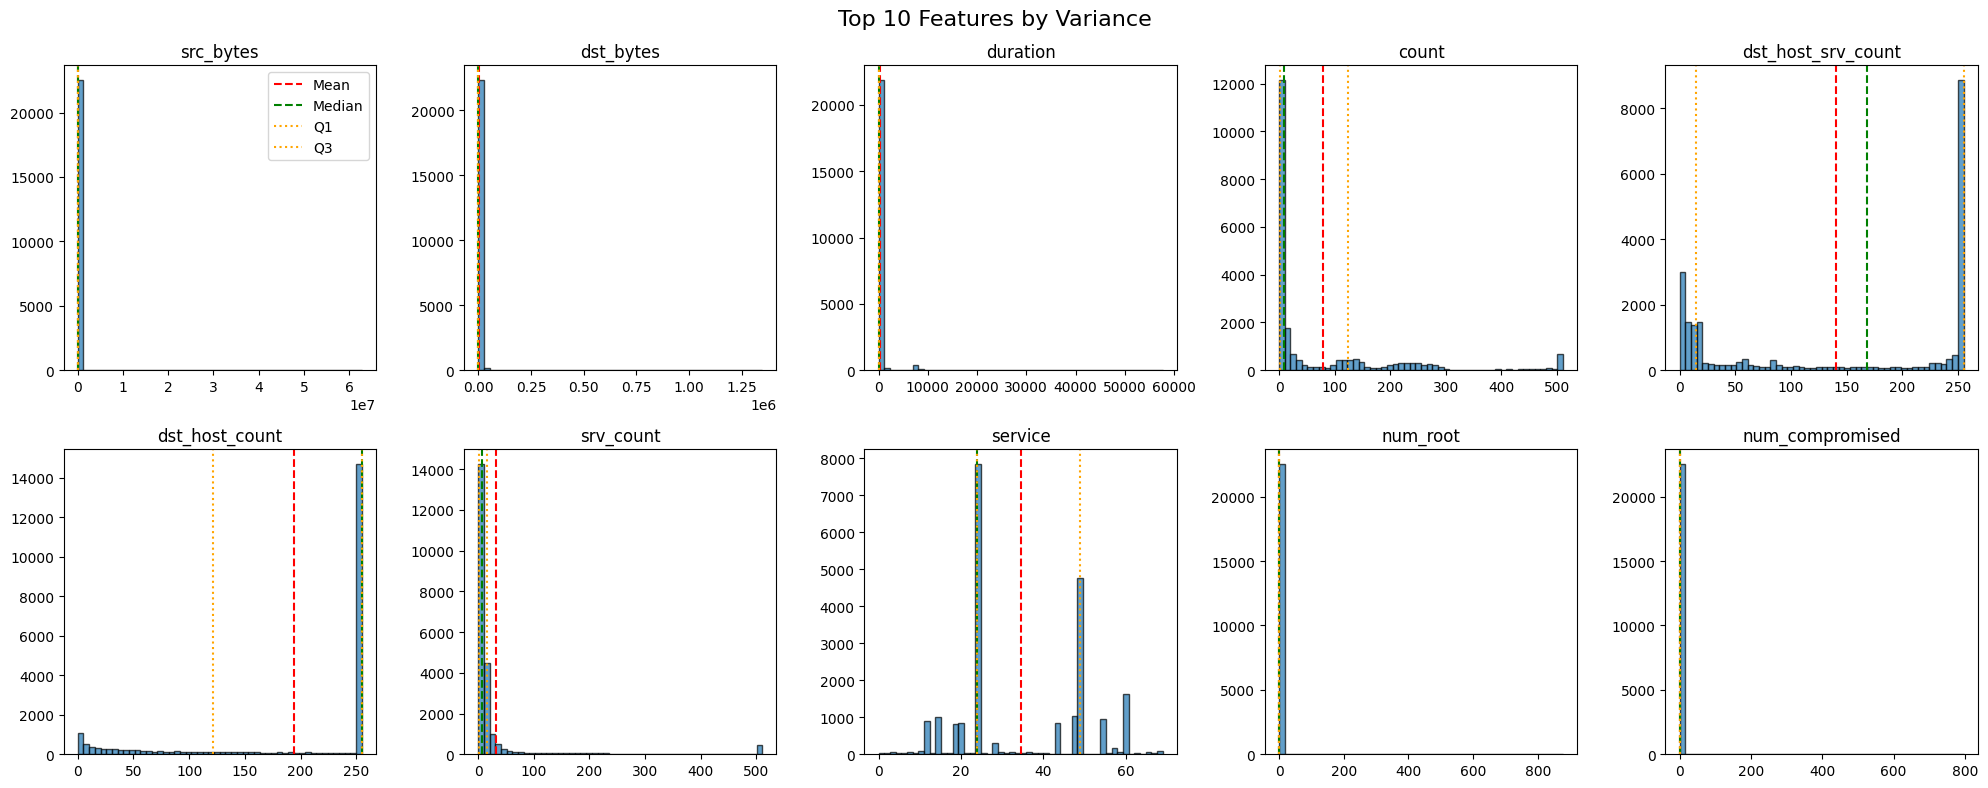


Analysis complete!


In [65]:


# Import Google Colab file upload module
from google.colab import files

class NetworkAnomalyDetector:
    def __init__(self):
        self.scaler = StandardScaler()
        self.isolation_forest = None
        self.dbscan = None
        self.label_encoders = {}
        self.feature_names = []
        self.statistical_thresholds = {}

    def load_nsl_kdd_data(self, train_file, test_file=None):
        column_names = [
            'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
            'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
            'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
            'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
            'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
            'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
            'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
            'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
        ]

        print("Loading NSL-KDD training data...")
        train_data = pd.read_csv(train_file, names=column_names)

        if test_file:
            print("Loading NSL-KDD test data...")
            test_data = pd.read_csv(test_file, names=column_names)
            return train_data, test_data

        return train_data

    def preprocess_data(self, data, target_col='label'):
        print("Preprocessing data...")
        df = data.copy()
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        if target_col in categorical_cols:
            categorical_cols.remove(target_col)

        for col in categorical_cols:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                df[col] = self.label_encoders[col].fit_transform(df[col].astype(str))
            else:
                df[col] = self.label_encoders[col].transform(df[col].astype(str))

        if target_col in df.columns:
            X = df.drop([target_col, 'difficulty'], axis=1, errors='ignore')
            y = df[target_col]
            if y.dtype == 'object':
                y_binary = (y != 'normal').astype(int)
            else:
                y_binary = y
        else:
            X = df
            y_binary = None

        X.fillna(X.median(), inplace=True)
        self.feature_names = X.columns.tolist()
        return X, y_binary

    def calculate_statistical_thresholds(self, X):
        print("Calculating statistical thresholds...")
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            mean_val = X[col].mean()
            std_val = X[col].std()
            z_lower = mean_val - 3 * std_val
            z_upper = mean_val + 3 * std_val
            self.statistical_thresholds[col] = {
                'iqr_lower': lower_bound,
                'iqr_upper': upper_bound,
                'z_lower': z_lower,
                'z_upper': z_upper
            }

    def detect_statistical_anomalies(self, X):
        print("Detecting statistical anomalies...")
        anomalies_iqr = np.zeros(len(X))
        anomalies_zscore = np.zeros(len(X))
        for col in X.columns:
            if col in self.statistical_thresholds:
                thresholds = self.statistical_thresholds[col]
                iqr_outliers = (X[col] < thresholds['iqr_lower']) | (X[col] > thresholds['iqr_upper'])
                anomalies_iqr += iqr_outliers.astype(int)
                z_outliers = (X[col] < thresholds['z_lower']) | (X[col] > thresholds['z_upper'])
                anomalies_zscore += z_outliers.astype(int)
        iqr_anomalies = (anomalies_iqr >= 2).astype(int)
        zscore_anomalies = (anomalies_zscore >= 2).astype(int)
        return iqr_anomalies, zscore_anomalies

    def train_isolation_forest(self, X, contamination=0.1):
        print("Training Isolation Forest...")
        X_scaled = self.scaler.fit_transform(X)
        self.isolation_forest = IsolationForest(
            contamination=contamination,
            random_state=42,
            n_estimators=100
        )
        self.isolation_forest.fit(X_scaled)
        predictions = self.isolation_forest.predict(X_scaled)
        anomaly_scores = self.isolation_forest.decision_function(X_scaled)
        anomalies = (predictions == -1).astype(int)
        return anomalies, anomaly_scores

    def train_dbscan(self, X, eps=0.5, min_samples=5):
        print("Training DBSCAN...")
        X_scaled = self.scaler.transform(X)
        pca = PCA(n_components=0.95)
        X_pca = pca.fit_transform(X_scaled)
        self.dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = self.dbscan.fit_predict(X_pca)
        anomalies = (clusters == -1).astype(int)
        return anomalies, clusters

    def evaluate_models(self, y_true, predictions_dict):
        print("\n" + "="*50)
        print("MODEL EVALUATION RESULTS")
        print("="*50)
        results = {}
        for method_name, y_pred in predictions_dict.items():
            print(f"\n{method_name.upper()} RESULTS:")
            print("-" * 30)
            report = classification_report(y_true, y_pred, output_dict=True)
            print(classification_report(y_true, y_pred))
            cm = confusion_matrix(y_true, y_pred)
            print(f"Confusion Matrix:\n{cm}")
            tn, fp, fn, tp = cm.ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            results[method_name] = {
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'accuracy': report['accuracy']
            }
            print(f"Precision: {precision:.4f}")
            print(f"Recall: {recall:.4f}")
            print(f"F1-Score: {f1:.4f}")
            print(f"Accuracy: {report['accuracy']:.4f}")
        return results

    def plot_results(self, X, y_true, predictions_dict, X_test_anomaly_scores=None):
        print("Creating visualizations...")
        X_scaled = self.scaler.transform(X)
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        n_methods = len(predictions_dict)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        # Ground truth plot
        scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_true, cmap='viridis', alpha=0.6)
        axes[0].set_title('Ground Truth')
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.colorbar(scatter, ax=axes[0])

        # Method predictions plots
        for i, (method_name, predictions) in enumerate(predictions_dict.items(), 1):
            if i < 5:  # Only plot first 4 methods to avoid index out of bounds
                scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=predictions, cmap='viridis', alpha=0.6)
                axes[i].set_title(f'{method_name}')
                axes[i].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
                axes[i].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
                plt.colorbar(scatter, ax=axes[i])

        # Anomaly scores plot (if provided and matches test data size)
        if X_test_anomaly_scores is not None and len(X_test_anomaly_scores) == len(X):
            scatter = axes[5].scatter(X_pca[:, 0], X_pca[:, 1], c=X_test_anomaly_scores, cmap='coolwarm', alpha=0.6)
            axes[5].set_title('Isolation Forest Anomaly Scores')
            axes[5].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            axes[5].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            plt.colorbar(scatter, ax=axes[5])
        else:
            # Hide the last subplot if no valid anomaly scores
            axes[5].set_visible(False)

        plt.tight_layout()
        plt.show()
        self.plot_feature_statistics(X)

    def plot_feature_statistics(self, X):
        feature_vars = X.var().sort_values(ascending=False).head(10)
        top_features = feature_vars.index.tolist()
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.ravel()
        for i, feature in enumerate(top_features):
            axes[i].hist(X[feature], bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'{feature}')
            axes[i].axvline(X[feature].mean(), color='red', linestyle='--', label='Mean')
            axes[i].axvline(X[feature].median(), color='green', linestyle='--', label='Median')
            Q1 = X[feature].quantile(0.25)
            Q3 = X[feature].quantile(0.75)
            axes[i].axvline(Q1, color='orange', linestyle=':', label='Q1')
            axes[i].axvline(Q3, color='orange', linestyle=':', label='Q3')
            if i == 0:
                axes[i].legend()
        plt.suptitle('Top 10 Features by Variance', fontsize=16)
        plt.tight_layout()
        plt.show()

def main():
    print("Network Traffic Anomaly Detection System")
    print("="*50)
    detector = NetworkAnomalyDetector()
    print("\nPlease ensure you have downloaded the NSL-KDD dataset from:")
    print("https://www.kaggle.com/datasets/hassan06/nslkdd")
    print("\nUploading files using Google Colab...")

    try:
        # STEP 1: Upload files using Google Colab's file upload dialog
        uploaded = files.upload()

        # Verify that both required files are uploaded
        if 'KDDTrain+.txt' not in uploaded or 'KDDTest+.txt' not in uploaded:
            raise FileNotFoundError("Please upload both KDDTrain+.txt and KDDTest+.txt")

        # STEP 2: Load the data
        train_file = 'KDDTrain+.txt'
        test_file = 'KDDTest+.txt'
        train_data, test_data = detector.load_nsl_kdd_data(train_file, test_file)

        # Preprocess data
        X_train, y_train = detector.preprocess_data(train_data)
        X_test, y_test = detector.preprocess_data(test_data)

        print(f"Training dataset shape: {X_train.shape}")
        print(f"Test dataset shape: {X_test.shape}")
        print(f"Training anomaly ratio: {y_train.sum() / len(y_train):.4f}")

        # Calculate statistical thresholds
        detector.calculate_statistical_thresholds(X_train)

        # Train models and detect anomalies
        print("\nTraining models and detecting anomalies...")

        # Isolation Forest
        if_anomalies, if_scores = detector.train_isolation_forest(X_train, contamination=y_train.mean())
        if_test_anomalies = (detector.isolation_forest.predict(detector.scaler.transform(X_test)) == -1).astype(int)
        # Get anomaly scores for test data
        if_test_scores = detector.isolation_forest.decision_function(detector.scaler.transform(X_test))

        # DBSCAN
        dbscan_anomalies, dbscan_clusters = detector.train_dbscan(X_train)
        X_test_scaled = detector.scaler.transform(X_test)
        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(detector.scaler.transform(X_train))
        X_test_pca = pca.transform(X_test_scaled)
        dbscan_test = DBSCAN(eps=0.5, min_samples=5)
        dbscan_test_clusters = dbscan_test.fit_predict(X_test_pca)
        dbscan_test_anomalies = (dbscan_test_clusters == -1).astype(int)

        # Statistical methods
        iqr_anomalies, zscore_anomalies = detector.detect_statistical_anomalies(X_test)

        # Combine predictions
        predictions = {
            'Isolation Forest': if_test_anomalies,
            'DBSCAN': dbscan_test_anomalies,
            'IQR Method': iqr_anomalies,
            'Z-Score Method': zscore_anomalies
        }

        # Evaluate models
        results = detector.evaluate_models(y_test, predictions)

        # Create ensemble prediction (majority vote)
        ensemble_pred = np.zeros(len(y_test))
        for pred in predictions.values():
            ensemble_pred += pred
        ensemble_pred = (ensemble_pred >= 2).astype(int)
        predictions['Ensemble'] = ensemble_pred
        detector.evaluate_models(y_test, {'Ensemble': ensemble_pred})

        # Visualize results with correct anomaly scores
        detector.plot_results(X_test, y_test, predictions, if_test_scores)

        print("\nAnalysis complete!")

    except FileNotFoundError as e:
        print(f"\nError: {e}")
        print("\nFor demonstration, generating synthetic network traffic data...")
        np.random.seed(42)
        n_samples = 10000
        n_features = 20
        X_normal = np.random.normal(0, 1, (int(n_samples * 0.9), n_features))
        X_anomaly = np.random.normal(3, 2, (int(n_samples * 0.1), n_features))
        X_synthetic = np.vstack([X_normal, X_anomaly])
        y_synthetic = np.hstack([np.zeros(len(X_normal)), np.ones(len(X_anomaly))])
        feature_cols = [f'feature_{i}' for i in range(n_features)]
        X_df = pd.DataFrame(X_synthetic, columns=feature_cols)
        X_train, X_test, y_train, y_test = train_test_split(
            X_df, y_synthetic, test_size=0.3, random_state=42, stratify=y_synthetic
        )
        print(f"Synthetic dataset shape: {X_df.shape}")
        print(f"Anomaly ratio: {y_synthetic.mean():.4f}")
        detector.calculate_statistical_thresholds(X_train)
        if_anomalies, if_scores = detector.train_isolation_forest(X_train, contamination=y_train.mean())
        if_test_anomalies = (detector.isolation_forest.predict(detector.scaler.transform(X_test)) == -1).astype(int)
        if_test_scores = detector.isolation_forest.decision_function(detector.scaler.transform(X_test))

        dbscan_anomalies, _ = detector.train_dbscan(X_train, eps=1.0, min_samples=10)
        X_test_scaled = detector.scaler.transform(X_test)
        pca = PCA(n_components=0.95)
        X_train_pca = pca.fit_transform(detector.scaler.transform(X_train))
        X_test_pca = pca.transform(X_test_scaled)
        dbscan_test = DBSCAN(eps=1.0, min_samples=10)
        dbscan_test_clusters = dbscan_test.fit_predict(X_test_pca)
        dbscan_test_anomalies = (dbscan_test_clusters == -1).astype(int)
        iqr_anomalies, zscore_anomalies = detector.detect_statistical_anomalies(X_test)
        predictions = {
            'Isolation Forest': if_test_anomalies,
            'DBSCAN': dbscan_test_anomalies,
            'IQR Method': iqr_anomalies,
            'Z-Score Method': zscore_anomalies
        }
        results = detector.evaluate_models(y_test, predictions)
        detector.plot_results(X_test, y_test, predictions, if_test_scores)
        print("\nSynthetic data analysis complete!")

if __name__ == "__main__":
    main()